___
# <center><a>A2C (Advantage Actor-Critic)<a/>
___

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecNormalize
from stable_baselines3.common.atari_wrappers import ClipRewardEnv


%load_ext tensorboard

___
## <center><a>Среда<a/>
___

Obseravtion space: Box(0, 255, (96, 96, 3), uint8)
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)


/home/nazarov/Github/RLCourse/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


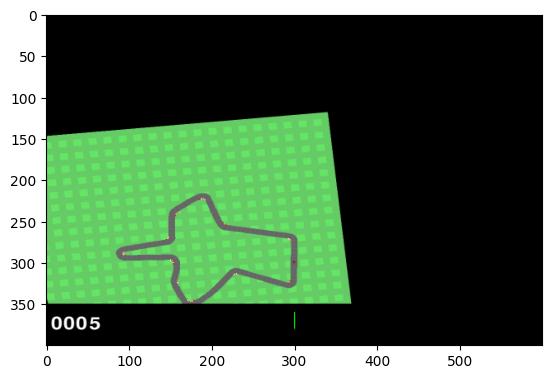

In [2]:
env_name = "CarRacing-v3"
env = gym.make(env_name, render_mode="rgb_array")
env.reset()

print(f"Obseravtion space: {env.observation_space}")
print(f"Action space: {env.action_space}")
plt.imshow(env.render())
plt.grid(visible=False)
plt.show();

Добавление в среду:
- `n_envs` : параллельные среды
- `norm_reward` : нормирование награды
- `n_stack` : склеить последовательные наблюдения

In [3]:
vec_env = make_vec_env(
    env_id=env_name,
    n_envs=4,
    seed=8
    )

vec_env = VecNormalize(
    venv = vec_env,
    norm_obs=False,
    norm_reward=True
    )
vec_env = VecFrameStack(
    venv=vec_env,
    n_stack=4
    )

obs = vec_env.reset()
print(f'[N-envs, H, W, N-stacked channels]: {obs.shape}')
print(f'Max/Min obs-values: {obs.max().item(), obs.min().item()}')

[N-envs, H, W, N-stacked channels]: (4, 96, 96, 12)
Max/Min obs-values: (253, 0)


___
## <center><a>Алгоритм</a>
___

Параметры:
- `policy`=CnnPolicy : использование сверточной нейронной сети
- `gamma`=0.995 : коэффициент дисконтирования, чем ближе к 1, тем больше учитываются `будущие награды`:
    - $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ : `TD-ошибка` (temporal difference residual)
        - $r_t$ : награда на шаге t
        - $\gamma$ : коэффициент дисконтирования
        - $V(s_t)$ : оценка ценности состояния критиком на шаге t
        - $V(s_{t+1})$ : ценность следующего состояния
- `gae_lambda`=0.955 : коэффициент компромисса bias/variance для GAE
    - $A_t^{GAE} = \sum_{l=0}^{L-1}(\gamma\lambda)^l\delta_{t+l}$ : `advantage` (насколько действие лучше/хуже среднего по состоянию)
        - $\lambda \rightarrow$ 1: меньше смещения, больше дисперсия
        - $\lambda \rightarrow$ 0: больше смещения, меньше дисперсия (ближе к 1-step TD advantage)
- `normalize_advantage`=False : нормализация advantage (при True)
    - $\hat{A_{t}} = \frac{A_t - \mu_A}{\sigma_A}$:
        - $\mu_A$ : средний advantage в текущем батче
        - $\sigma_A$ : стандартное отклонение advantage в текущем батче
- `Лосс-функция A2C`: $L_{A2C} = L_{policy} + c_{ent}L_{entropy} + c_{vf}L_{vf}$
- `ent_coef`: коэффициент лосс-функции энтропии в общей лосс-функции A2C:
    - $c_{ent} \rightarrow$ 1: больше исследования
    - $c_{ent} \rightarrow$ 0: меньше исследования
- `vf_coef`: коэффициент лосс-функции Value-function (критик) в общей лосс-функции A2C:
    - $c_{vf} \rightarrow$ 1: сильнее обучаеncя критик
    - $c_{vf} \rightarrow$ 0: сильнее обучаеncz политика
- `max_grad_norm`=2 : максимальная норма градиента, выполняя обрезание градиента, защищая от взрыва градиента
- `n_steps`=64: кол-во шагов каждой среды (`n_steps` $\times$ `n_envs`) для градиентного спуска `policy + vf`

In [ ]:
algo = A2C(
    device='cuda:0',
    tensorboard_log='./results/',
    env=vec_env,
    learning_rate=3e-5,
    policy='CnnPolicy',
    gamma=0.995,
    gae_lambda=0.955,
    normalize_advantage=False,
    ent_coef=0.000001,
    vf_coef=0.15,
    max_grad_norm=2,
    n_steps=64,
    verbose=1,
    )


Using cuda:0 device
Wrapping the env in a VecTransposeImage.


___
## <center><a>Обучение<a/>
___

In [ ]:
algo.learn(
    total_timesteps=1000_000,
    tb_log_name='CarRacing_A2C',
    log_interval=5
    )

algo.save("CarRacing_A2C")

___
## <center><a>Результаты<a/>
___

In [11]:
%tensorboard --logdir='/home/nazarov/Github/RLCourse/Practice/3. A2C/results'

Reusing TensorBoard on port 6007 (pid 38704), started 0:09:36 ago. (Use '!kill 38704' to kill it.)

<img src='./results/mean_rews.png'></img>